# GP Applied to the Even-Parity Problem with multiple runs.

Now that we understand what's going on at the single-run level, let's modify our code to do multiple runs. Notice the similarity between this code and the sample code for GA with multiple runs. 

First, let's widen our display.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


Import our tools.

In [2]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters, one of which is now the number of runs.

In [3]:
# Genetic Programming constants:
POPULATION_SIZE = 2000
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 30
HALL_OF_FAME_SIZE = 10

N_RUNS = 30




Set the random seed. 

In [4]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

GP-Specific constants.

In [5]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. 

In [6]:
NUM_INPUTS = 6
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [7]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)
    
# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

Add our functions and terminals. This time we are using Boolean operators and values.

In [8]:
# create the primitive set:
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)
primitiveSet.addPrimitive(operator.xor, 2)
primitiveSet.addPrimitive(operator.not_, 1)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)

Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [9]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=primitiveSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=primitiveSet)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



Set up our population as before

Create our statistics. These are a bit more complex than the GA ones because we want to keep track of fitness and size for all runs.

In [10]:
maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []

maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []

Now the magic happens and we run **N_RUNS** times. Always start with a small number of runs and generations to make sure that everything is working properly before you commit to a larger number. That way, if something goes horribly wrong, Python won't replicate it 30 times before giving you back control!

In [11]:
for r in range(0, N_RUNS):
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


    # Create our statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    
    # Which run are we on?
    print("\n\nCurrently on run", r, "of",N_RUNS)
    
    
    
    population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)
    
    #maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")
    meanFitnessValues, stdFitnessValues, minFitnessValues, maxFitnessValues  = logbook.chapters['fitness'].select("avg", "std", "min", "max")
    meanSizeValues, stdSizeValues, minSizeValues, maxSizeValues  = logbook.chapters['size'].select("avg", "std", "min", "max")


    # Save statistics for this run:
    avgListFitness.append(meanFitnessValues)
    stdListFitness.append(stdFitnessValues)
    minListFitness.append(minFitnessValues)
    maxListFitness.append(maxFitnessValues)
    
    avgListSize.append(meanSizeValues)
    stdListSize.append(stdSizeValues)
    minListSize.append(minSizeValues)
    maxListSize.append(maxSizeValues)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- length={}, height={}".format(len(best), best.height))
    print("-- Best Fitness = ", best.fitness.values[0])





Currently on run 0 of 30
   	      	                    fitness                     	                     size                     
   	      	------------------------------------------------	----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg    	gen	max	min	nevals	std   
0  	2000  	32.009	0  	40 	24 	2000  	0.671505	22.5945	0  	60 	4  	2000  	13.194
1  	1816  	31.9305	1  	40 	24 	1816  	0.6969  	23.144 	1  	69 	2  	1816  	14.243
2  	1778  	31.8885	2  	40 	16 	1778  	0.924158	24.1045	2  	81 	1  	1778  	15.3416
3  	1801  	31.865 	3  	40 	16 	1801  	1.03527 	25.423 	3  	81 	2  	1801  	16.1789
4  	1796  	31.791 	4  	40 	22 	1796  	1.12708 	26.556 	4  	92 	2  	1796  	17.4976
5  	1817  	31.6685	5  	40 	23 	1817  	1.2902  	27.6965	5  	91 	1  	1817  	18.3071
6  	1810  	31.5675	6  	38 	22 	1810  	1.48608 	30.0145	6  	113	2  	1810  	19.427 
7  	1802  	31.3585	7  	40 	20 	1802  	1.79999 	33.1   	7  	113	2  	1802  	21.2185
8  	1802  	31.089 	8  	40 

19 	1826  	29.11  	19 	48 	14 	1826  	3.41949 	69.063 	19 	187	1  	1826  	27.6642
20 	1833  	28.868 	20 	48 	12 	1833  	3.73879 	71.9275	20 	205	3  	1833  	28.7486
21 	1801  	28.3305	21 	46 	12 	1801  	3.9737  	74.924 	21 	206	1  	1801  	29.7798
22 	1819  	27.773 	22 	48 	8  	1819  	4.33514 	77.279 	22 	191	1  	1819  	30.105 
23 	1814  	27.2065	23 	46 	4  	1814  	4.73274 	79.6915	23 	195	3  	1814  	30.0148
24 	1795  	26.4135	24 	46 	0  	1795  	5.30561 	81.292 	24 	198	2  	1795  	30.223 
25 	1792  	25.5185	25 	45 	3  	1792  	5.86103 	82.88  	25 	199	2  	1792  	30.9381
26 	1792  	24.402 	26 	52 	1  	1792  	6.27124 	84.4435	26 	212	5  	1792  	30.4188
27 	1800  	23.6545	27 	62 	4  	1800  	6.94278 	85.308 	27 	216	2  	1800  	31.4175
28 	1826  	22.818 	28 	48 	4  	1826  	7.07558 	85.387 	28 	233	3  	1826  	31.8562
29 	1814  	22.1955	29 	60 	2  	1814  	7.7574  	86.7345	29 	194	3  	1814  	31.3527
30 	1811  	21.2345	30 	52 	0  	1811  	7.88445 	87.543 	30 	185	4  	1811  	31.6208
-- Best Individu

   	      	                    fitness                     	                     size                     
   	      	------------------------------------------------	----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg    	gen	max	min	nevals	std   
0  	2000  	32.011	0  	40 	24 	2000  	0.896593	23.1165	0  	61 	4  	2000  	13.532
1  	1791  	31.9145	1  	36 	24 	1791  	0.721242	23.323 	1  	76 	2  	1791  	14.0822
2  	1818  	31.9015	2  	40 	24 	1818  	0.860115	24.7995	2  	90 	2  	1818  	15.1198
3  	1810  	31.84  	3  	36 	24 	1810  	0.886228	25.278 	3  	93 	2  	1810  	15.8338
4  	1808  	31.8115	4  	40 	24 	1808  	1.03921 	25.965 	4  	108	1  	1808  	16.6993
5  	1814  	31.7625	5  	40 	24 	1814  	1.23333 	27.457 	5  	108	1  	1814  	18.3963
6  	1803  	31.6805	6  	44 	16 	1803  	1.35034 	29.558 	6  	110	1  	1803  	20.4817
7  	1751  	31.543 	7  	40 	16 	1751  	1.45229 	32.9005	7  	113	1  	1751  	22.3578
8  	1806  	31.4435	8  	48 	24 	1806  	1.66066 	36.37

18 	1775  	28.7325	18 	44 	8  	1775  	3.69756 	87.88  	18 	242	3  	1775  	31.7753
19 	1831  	28.3665	19 	44 	12 	1831  	3.95198 	90.448 	19 	260	2  	1831  	31.6404
20 	1808  	27.7795	20 	48 	8  	1808  	4.21603 	93.693 	20 	242	7  	1808  	32.6027
21 	1802  	27.2415	21 	48 	8  	1802  	4.5732  	95.9055	21 	244	8  	1802  	33.1527
22 	1818  	26.764 	22 	48 	8  	1818  	5.08629 	95.698 	22 	246	1  	1818  	33.6802
23 	1821  	26.071 	23 	48 	8  	1821  	5.22618 	96.1185	23 	241	10 	1821  	34.2139
24 	1790  	25.389 	24 	56 	8  	1790  	5.82054 	95.5645	24 	257	3  	1790  	35.2669
25 	1791  	24.5585	25 	48 	4  	1791  	6.32926 	95.398 	25 	240	3  	1791  	34.6596
26 	1806  	23.6645	26 	48 	4  	1806  	6.66558 	95.415 	26 	240	6  	1806  	35.8382
27 	1833  	22.7705	27 	48 	0  	1833  	7.17703 	93.1325	27 	240	2  	1833  	36.0935
28 	1820  	21.9085	28 	52 	0  	1820  	7.77953 	90.546 	28 	258	7  	1820  	36.8385
29 	1802  	21.25  	29 	64 	0  	1802  	7.84732 	87.319 	29 	245	1  	1802  	35.7831
30 	1787  	20.61

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	2000  	32.005	0  	44 	16 	2000  	0.773288	22.816	0  	63 	4  	2000  	13.4956
1  	1775  	31.9395	1  	48 	16 	1775  	0.898799	22.4135	1  	75 	1  	1775  	13.689 
2  	1786  	31.9005	2  	44 	16 	1786  	0.96312 	23.172 	2  	84 	1  	1786  	14.7313
3  	1796  	31.8965	3  	48 	22 	1796  	0.969427	24.2495	3  	99 	1  	1796  	15.9034
4  	1786  	31.817 	4  	40 	22 	1786  	1.00574 	24.948 	4  	106	1  	1786  	17.0813
5  	1835  	31.769 	5  	40 	22 	1835  	1.11384 	26.334 	5  	106	1  	1835  	17.8439
6  	1834  	31.713 	6  	38 	22 	1834  	1.18938 	27.7495	6  	96 	1  	1834  	18.7752
7  	1813  	31.6405	7  	42 	22 	1813  	1.39365 	30.6755	7  	99 	1  	1813  	20.1777
8  	1811  	31.517 	8  	38 	20 	1811  	1.5449  	33.

15 	1816  	29.9085	15 	42 	16 	1816  	2.79287 	64.987 	15 	171	3  	1816  	26.797 
16 	1814  	29.6345	16 	40 	16 	1814  	2.9636  	68.336 	16 	171	3  	1814  	27.2702
17 	1800  	29.215 	17 	42 	16 	1800  	3.2611  	73.683 	17 	170	3  	1800  	27.8736
18 	1817  	28.9255	18 	44 	16 	1817  	3.49384 	76.842 	18 	187	3  	1817  	28.5057
19 	1780  	28.4355	19 	42 	16 	1780  	3.64922 	80.116 	19 	189	1  	1780  	28.5679
20 	1790  	28.043 	20 	48 	16 	1790  	3.86396 	82.704 	20 	173	3  	1790  	28.9015
21 	1783  	27.566 	21 	44 	16 	1783  	4.07144 	86.555 	21 	195	3  	1783  	30.3285
22 	1791  	27.099 	22 	44 	0  	1791  	4.09819 	90.106 	22 	211	1  	1791  	30.6777
23 	1780  	26.5955	23 	44 	16 	1780  	4.2418  	93.337 	23 	211	1  	1780  	31.6085
24 	1816  	26.102 	24 	42 	16 	1816  	4.42771 	97.898 	24 	208	1  	1816  	32.1768
25 	1832  	25.6345	25 	44 	16 	1832  	4.55565 	101.567	25 	208	7  	1832  	33.2605
26 	1804  	25.0785	26 	44 	8  	1804  	4.66598 	105.219	26 	216	6  	1804  	34.561 
27 	1826  	24.58

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	2000  	32.0155	0  	44 	24 	2000  	0.803281	23.095	0  	62 	4  	2000  	13.8535
1  	1774  	31.92  	1  	42 	24 	1774  	0.757364	22.8645	1  	82 	1  	1774  	14.6232
2  	1815  	31.843 	2  	40 	16 	1815  	0.972806	23.824 	2  	83 	1  	1815  	15.4038
3  	1825  	31.784 	3  	36 	16 	1825  	1.09195 	25.4125	3  	88 	1  	1825  	16.3838
4  	1815  	31.723 	4  	40 	16 	1815  	1.23583 	27.065 	4  	104	1  	1815  	17.7395
5  	1781  	31.629 	5  	36 	16 	1781  	1.2986  	29.9075	5  	104	1  	1781  	19.6045
6  	1826  	31.4775	6  	48 	16 	1826  	1.56764 	33.5875	6  	109	1  	1826  	21.5127
7  	1798  	31.3065	7  	40 	20 	1798  	1.63999 	37.953 	7  	117	1  	1798  	23.3363
8  	1817  	31.1955	8  	40 	20 	1817  	1.72866 	4

18 	1802  	29.063 	18 	48 	8  	1802  	3.58051 	74.1385	18 	195	3  	1802  	25.3323
19 	1798  	28.5175	19 	44 	8  	1798  	3.88171 	77.19  	19 	198	3  	1798  	26.6516
20 	1778  	28.1395	20 	44 	8  	1778  	4.22268 	78.9865	20 	214	6  	1778  	27.9282
21 	1822  	27.335 	21 	50 	8  	1822  	4.48294 	83.024 	21 	212	3  	1822  	28.8096
22 	1809  	26.9055	22 	48 	8  	1809  	4.99646 	85.404 	22 	219	1  	1809  	29.986 
23 	1808  	26.4165	23 	48 	8  	1808  	5.18729 	86.896 	23 	248	1  	1808  	31.1446
24 	1804  	25.6585	24 	56 	0  	1804  	5.7077  	90.066 	24 	240	1  	1804  	33.0689
25 	1808  	24.9645	25 	56 	0  	1808  	6.18298 	93.3675	25 	240	1  	1808  	33.7048
26 	1809  	24.061 	26 	48 	0  	1809  	6.48585 	97.1245	26 	240	2  	1809  	35.8327
27 	1790  	23.0535	27 	56 	0  	1790  	6.70639 	100.172	27 	251	5  	1790  	38.7542
28 	1830  	22.271 	28 	56 	0  	1830  	7.02706 	103.942	28 	245	8  	1830  	41.1248
29 	1793  	21.2445	29 	56 	0  	1793  	7.24857 	106.734	29 	243	3  	1793  	42.782 
30 	1816  	20.54

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	2000  	32.005	0  	48 	24 	2000  	0.863698	23.078	0  	61 	4  	2000  	13.4461
1  	1823  	31.9005	1  	40 	24 	1823  	0.812157	23.1545	1  	83 	2  	1823  	13.9326
2  	1837  	31.876 	2  	40 	24 	1837  	0.995803	23.9585	2  	88 	2  	1837  	14.7012
3  	1832  	31.862 	3  	40 	14 	1832  	1.1018  	24.2695	3  	90 	1  	1832  	15.2639
4  	1811  	31.796 	4  	36 	14 	1811  	1.21136 	24.8215	4  	98 	1  	1811  	15.8604
5  	1819  	31.7165	5  	40 	8  	1819  	1.49604 	25.545 	5  	99 	1  	1819  	17.2881
6  	1809  	31.643 	6  	64 	13 	1809  	1.9054  	27.6195	6  	105	1  	1809  	18.7541
7  	1819  	31.4735	7  	51 	2  	1819  	2.18089 	29.972 	7  	125	1  	1819  	20.5271
8  	1807  	31.3105	8  	53 	2  	1807  	2.54815 	32.

19 	1807  	26.0065	19 	44 	16 	1807  	5.46886 	63.297 	19 	176	1  	1807  	27.4442
20 	1823  	25.03  	20 	46 	16 	1823  	5.71901 	64.0545	20 	181	1  	1823  	28.4421
21 	1803  	24.2985	21 	48 	16 	1803  	6.1065  	63.888 	21 	179	5  	1803  	28.6007
22 	1807  	23.096 	22 	48 	12 	1807  	6.05556 	63.7935	22 	179	6  	1807  	28.2589
23 	1772  	22.3615	23 	48 	12 	1772  	6.22815 	64.936 	23 	183	1  	1772  	28.074 
24 	1820  	21.8145	24 	48 	12 	1820  	6.32867 	64.7875	24 	181	1  	1820  	28.3215
25 	1797  	21.481 	25 	48 	12 	1797  	6.41417 	65.9155	25 	184	6  	1797  	28.972 
26 	1786  	20.8295	26 	44 	10 	1786  	6.36407 	67.582 	26 	189	1  	1786  	28.6628
27 	1813  	20.422 	27 	48 	10 	1813  	6.25675 	67.9365	27 	161	1  	1813  	28.8938
28 	1804  	20.4335	28 	48 	10 	1804  	6.47862 	69.0435	28 	162	1  	1804  	29.7913
29 	1834  	20.226 	29 	48 	8  	1834  	6.544   	70.6315	29 	179	8  	1834  	29.4727
30 	1796  	20.0985	30 	48 	8  	1796  	6.61723 	72.8005	30 	210	3  	1796  	29.8182
-- Best Individu

1  	1801  	31.926	1  	40 	16 	1801  	0.884038	22.93  	1  	78 	2  	1801  	13.5819
2  	1796  	31.9095	2  	40 	16 	1796  	0.842205	22.9355	2  	83 	1  	1796  	14.1194
3  	1809  	31.9195	3  	44 	24 	1809  	0.827659	23.894 	3  	79 	1  	1809  	14.8554
4  	1804  	31.842 	4  	36 	22 	1804  	0.895565	24.7605	4  	78 	1  	1804  	15.3706
5  	1824  	31.8625	5  	40 	20 	1824  	0.94106 	25.827 	5  	84 	1  	1824  	16.5459
6  	1773  	31.7855	6  	38 	20 	1773  	1.00024 	26.953 	6  	101	1  	1773  	17.3666
7  	1823  	31.751 	7  	40 	20 	1823  	1.20416 	28.7245	7  	105	1  	1823  	18.6638
8  	1782  	31.7075	8  	42 	20 	1782  	1.19664 	30.793 	8  	115	1  	1782  	20.227 
9  	1818  	31.5975	9  	38 	21 	1818  	1.34331 	32.994 	9  	112	1  	1818  	21.1862
10 	1809  	31.4945	10 	40 	20 	1809  	1.49866 	36.501 	10 	119	1  	1809  	23.1464
11 	1810  	31.3455	11 	48 	16 	1810  	1.73468 	40.3105	11 	131	1  	1810  	24.5911
12 	1824  	31.1555	12 	44 	16 	1824  	1.93296 	44.682 	12 	130	1  	1824  	24.9944
13 	1818  	30.899

18 	1800  	29.1025	18 	40 	14 	1800  	3.54979 	68.2065	18 	177	1  	1800  	28.3919
19 	1822  	28.603 	19 	48 	14 	1822  	3.89543 	71.9075	19 	185	1  	1822  	29.8012
20 	1790  	27.8485	20 	45 	12 	1790  	4.388   	77.0035	20 	177	3  	1790  	30.572 
21 	1812  	27.1125	21 	50 	12 	1812  	4.7357  	80.5975	21 	197	3  	1812  	31.3457
22 	1780  	26.0495	22 	48 	8  	1780  	5.18518 	83.605 	22 	187	3  	1780  	31.9263
23 	1802  	25.152 	23 	48 	8  	1802  	5.57296 	86.519 	23 	199	3  	1802  	33.238 
24 	1795  	24.2945	24 	47 	8  	1795  	5.89498 	87.158 	24 	217	3  	1795  	34.4818
25 	1814  	22.964 	25 	49 	8  	1814  	5.98212 	89.859 	25 	224	1  	1814  	34.5594
26 	1796  	21.847 	26 	48 	8  	1796  	6.23062 	91.3305	26 	219	1  	1796  	33.998 
27 	1815  	21.123 	27 	49 	8  	1815  	6.63414 	92.608 	27 	222	1  	1815  	35.2068
28 	1799  	20.279 	28 	56 	8  	1799  	6.8369  	95.4235	28 	214	3  	1799  	35.4259
29 	1823  	19.234 	29 	46 	0  	1823  	6.69038 	95.5445	29 	219	10 	1823  	34.9991
30 	1774  	18.34

Create our graphs using the averages across all the runs. Notice how we use standard deviation to show how much variation there is in the runs.

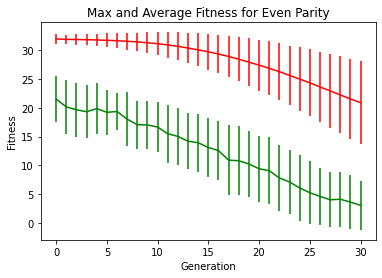

In [12]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListFitness)
stdArray = numpy.array(stdListFitness)
minArray = numpy.array(minListFitness)
maxArray = numpy.array(maxListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Best and Average Fitness for Even Parity')
plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Green")
plt.show()

Show the graph for size.

In [ ]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListS)
stdArray = numpy.array(stdListFitness)
minArray = numpy.array(minListFitness)
maxArray = numpy.array(maxListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Max and Average Fitness for Even Parity')
plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Green")
plt.show()